# How to calculate first derivatives

In this guide we discuss how to compute first derivatives with ``estimagic``. In the introduction we first introduce some core concepts. Aftwards we extend the scalar case to gradients and jacobians. Then we present a useful visual debugging feature and at last we talk about multiprocessing. For even more details on arguments and outputs see the API Reference.

In [1]:
import warnings
from functools import partial

import numpy as np
import pandas as pd

from estimagic.differentiation.derivatives import first_derivative
from estimagic.visualization.derivative_plot import derivative_plot

## Introduction

Lets start with differentiating a simple function, say a parabola. We want to differentiate the function $f(x) = x^2$, which we write in Python as

In [2]:
def f(x):
    return x**2

The derivative of $f$ is given by $f'(x) = 2 x$. As we are computing numerical derivatives we have to specify the value of $x$ at which we want to compute the derivative. We will consider two points points $x = 0$ and $x=1$ which gives $f'(0) = 0$ and $f'(1) = 2$.

To compute the derivative using ``estimagic`` we simply pass the function ``f`` and the ``params`` vector at which we want to evaluate the derivative to the function ``first_derivative``:

In [3]:
params = 0

derivative = first_derivative(f, params)

derivative["derivative"]

array(0.)

In [4]:
params = 1

derivative = first_derivative(f, params)

derivative["derivative"]

array(2.)

Notice that the output of ``first_derivative`` is a dictionary containing the derivative under the key "derivative".

## Gradient and Jacobian

The scalar case from above extends seamlessly to the multivariate case. Let us therefore consider two cases: (1) $f_1: \mathbb{R}^N \to \mathbb{R}$ and (2) $f_2: \mathbb{R}^N \to \mathbb{R}^M$. The first derivative of $f_1$ is usually referred to as the gradient while the first derivative of $f_2$ is usually called the Jacobian.

Lets choose simple functions $f_1(x) = \sum_{n = 1}^N x_n^2$ and $f_2 = Ax$, where $A$ is a ($M \times N$) matrix full of ones except for the very first entry $A_{1, 1} = 20$. We know that the gradient of $f_1$ is given as $\nabla f_1 (x) = 2 x^\top$ and the Jacobian of $f_2$ is given as $J(f_2)(x) = A$. Lets see if we can reproduce this result using the ``first_derivative`` function.

In [5]:
def f1(x):
    return np.sum(x**2)


def f2(x, M):
    A = np.ones((M, len(x)))
    A[0, 0] = 20
    return A @ x


N, M = 3, 2

params = np.ones(N)

In [6]:
derivative = first_derivative(f1, params)
derivative["derivative"]

array([2., 2., 2.])

In [7]:
derivative = first_derivative(partial(f2, M=M), params)
derivative["derivative"]

array([[20.,  1.,  1.],
       [ 1.,  1.,  1.]])

## The output of ``first_derivative``

As we have already seen in the introduction, the output of ``first_derivative`` is a dictionary. This dictionary **always** contains an entry "derivative" which is the numerical derivative. Besides this entry several additional entries can be found conditional on the state of certain arguments.

**``return_func_value``**

If the argument ``return_func_value`` is ``True`` the output dictionary will contain an additional entry under the key "func_value" denoting the function value evaluated at the params vector.

**``return_info``**

If the argument ``return_info`` is ``True`` the output dictionary will contain one to two additional entries. In this case it will always contain the entry "func_evals" which is a data frame containing all internally executed function evaluations. And if ``n_steps`` is larger than 1, it will also contain "derivative_candidates", which is a data frame containing derivative estimates used in the Richardson extrapolation.

> For an explaination of the argument ``n_steps`` and the Richardson method please see the API Reference and the Richardson Extrapolation explaination in the documentation.


The objects returned when ``return_info`` is ``True`` are rarely of any use directly and can be safely ignored. However, they are necessary data when using the plotting function ``derivative_plot`` as explained below. For a better understanding we print each of these additional objects once:

In [8]:
derivative = first_derivative(f, 0, n_steps=2, return_func_value=True, return_info=True)

In [9]:
derivative["func_value"] == f(0)

True

In [10]:
derivative["func_evals"]

step          eval
sign step_number dim_x dim_f                            
 1   0           0     0      1.490116e-09  2.220446e-18
     1           0     0      2.980232e-09  8.881784e-18
-1   0           0     0      1.490116e-09  2.220446e-18
     1           0     0      2.980232e-09  8.881784e-18

In [11]:
derivative["derivative_candidates"]

,,,,der,err
method,num_term,dim_x,dim_f,,
forward,1,0,0,4.470348e-09,8.467417e-08
backward,1,0,0,-4.470348e-09,8.467417e-08
central,1,0,0,0.000000e+00,0.000000e+00


## The params argument

Above we used a ``numpy.ndarray`` as the ``params`` argument. ``estimagic`` is designed to work very well with named params, especially ``pandas.Series`` and ``pandas.DataFrame``. In the case where the function to evaluate uses a data frame the application is the same. Consider the below function ``h`` and the corresponding ``params`` argument:

In [12]:
def h(params):
    a = params.loc[("time_pref", "delta"), "value"] ** 2
    b = params.loc[("time_pref", "beta"), "value"] ** 2
    return a + b

In [13]:
params = pd.DataFrame(
    [["time_pref", "delta", 0.9], ["time_pref", "beta", 0.6], ["price", "price", 2]],
    columns=["category", "name", "value"],
).set_index(["category", "name"])

Nothing changes if we want to compute the derivative, however, output is a named ``pandas.Series`` now, which makes it easier to match the derivative value with a specific parameter. 

In [14]:
derivative = first_derivative(h, params)

In [15]:
derivative["derivative"]

category   name 
time_pref  delta    1.8
           beta     1.2
price      price    0.0
dtype: float64

## Plotting

In many cases one is interested in analyzing the estimated numerical derivative more closely. This can be helpful when one is debugging an optimization process which is stuck etc. The derivatives are drawn as the first-order Taylor approximation.

The function ``derivative_plot`` works on the dictionary returned by ``first_derivative``, as long as ``return_func_value`` and ``return_info`` are set to True and ``n_steps`` is larger than 1.

The figure visualizes the function evaluations, the best estimate of the derivative and forward, central and backward derivative estimates. Forward and backward estimates come with bands that are calculated by applying the standard (forward/backward) formula on the smallest and largest possible steps. **These bands are not confidence intervals**, they shall merely give a rough overview where the true derivative may lie.

In [16]:
derivative = first_derivative(f, 0, n_steps=4, return_func_value=True, return_info=True)

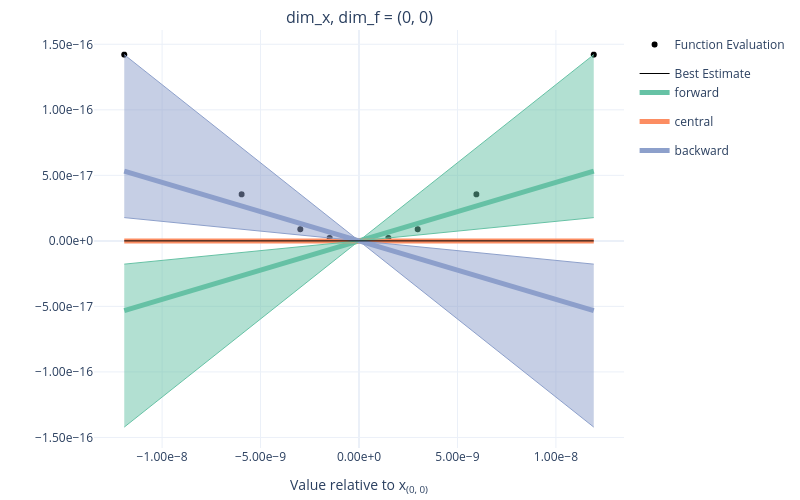

In [17]:
fig = derivative_plot(derivative)
fig = fig.update_layout(width=800, height=500)
fig.show(renderer="png")

### Multivariate functions

For multivariate input or output functions the plot generalizes seamlessly:

In [18]:
def g(x):
    y1 = x[0] ** 3 + x[1]
    y2 = x[2] ** 2 - x[0]
    return np.array([y1, y2])


params = np.zeros(3)

In [19]:
derivative = first_derivative(
    g, params, n_steps=4, return_func_value=True, return_info=True
)

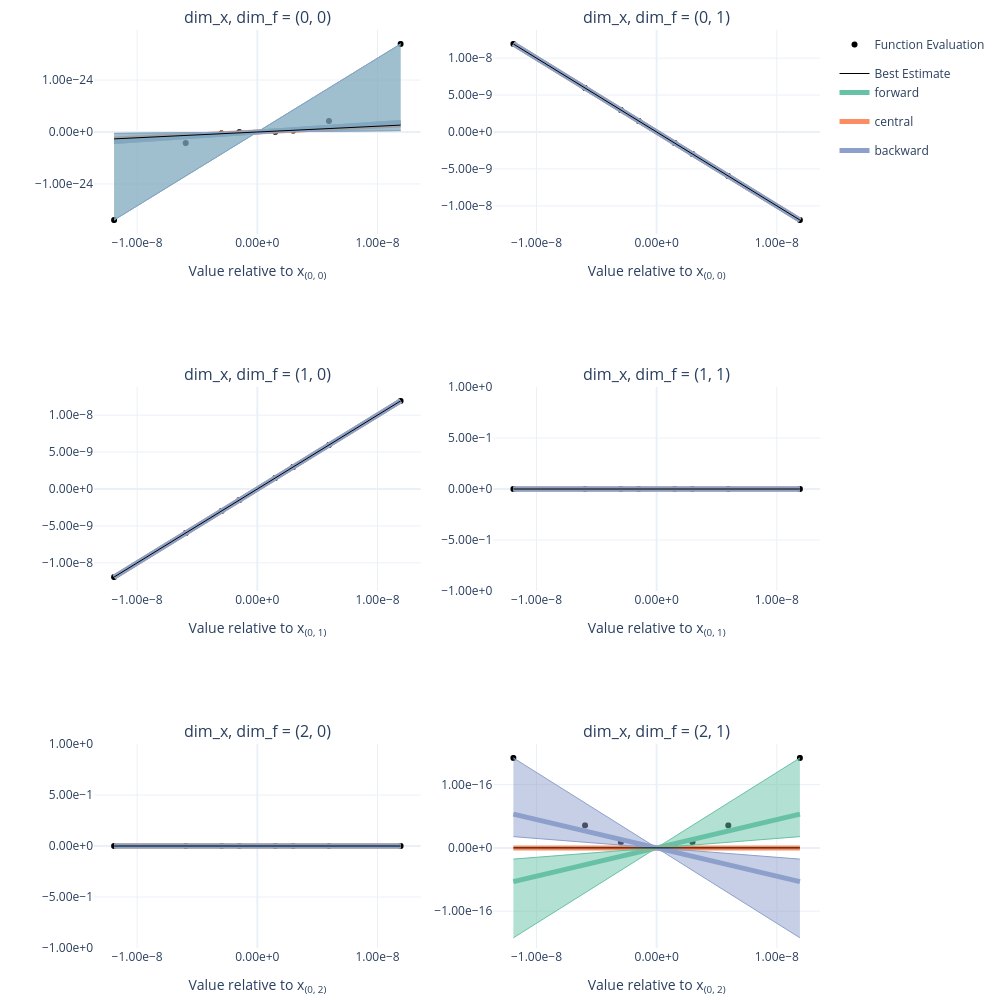

In [20]:
fig = derivative_plot(derivative)
fig = fig.update_layout(height=1000, width=1000)
fig.show(renderer="png")

## Multiprocessing

For slow-to-evaluate functions one may increase computation speed by running the function evaluations in parallel. This can be easily done by setting the ``n_cores`` argument. For example, if we wish to evaluate the function on ``2`` cores we simply write

In [21]:
derivative = first_derivative(f, params=0, n_cores=2)